In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *
mpl_settings()
paper_plot()

In [2]:
def bucket_return_bwc(params,ts):
    wd = 1000 # density of water (kg/m3)
    swc_init,swc_max,swc_min,swc_sos,swc_eos,sd,et = params
    swc = ts*np.nan # create empty ts
    lonset,lretreat = [],[]
    SOS_temp,EOS_temp = [],[]

    j = -1
    for i in range(len(ts)):
        if i % 365 == 0: #reset year
            if i==0: 
                swc[i] = swc_init
            else:
                swc[i] = swc[i-1]

                if len(SOS_temp) > 0:
                    lonset.append(max(SOS_temp))
                else:
                    lonset.append(-9999)
                if len(EOS_temp) > 0:
                    lretreat.append(max(EOS_temp))
                else:
                    lretreat.append(-9999)            

            j+=1 #year counter
            sos_flag = 0
            yearly_max = 0
            eos_flag = 1
            SOS_temp,EOS_temp = [],[]
        else:
            swc[i] =   swc[i-1] 

        swc[i] = swc[i] + (ts[i] - et) / sd / wd

        #if maximum sw is exceeded, no further increase in swc (surplus runs off)
        if swc[i] > swc_max:
            swc[i] = swc_max

        # if minimum swc is reached, no further drawdown occurs
        if swc[i] < swc_min:
            swc[i] = swc_min

        # constantly update yearly maximum swc
        if swc[i] > yearly_max:
            yearly_max = swc[i]

        # simulated sos occurs when critical swc is exceeded first time in fall
        if (swc[i] > swc_sos) and (sos_flag == 0):
            sos = (i+0) - j*365 # i starts at 0 (+1) and j*365 gives you the day since 01-09
            if sos < 10: #rarely early detections can happen
                pass
            else:
                SOS_temp.append(sos)
                sos_flag = 1; 

        # set flag for EOS condition to occur
        if (swc[i] > swc_eos) & (eos_flag == 1):
            eos_flag = 0;    

        # simulated eos occurs after yearly maximum swc has been reached and
        # swc falls below critical value
        if (swc[i] < yearly_max) & (swc[i] < swc_eos) & (eos_flag == 0):
            eos = (i+0) - j*365
            EOS_temp.append(eos)
            eos_flag = 1
    
    #after last iteration append SOS,EOS one last time
    if len(SOS_temp) > 0:
        lonset.append(max(SOS_temp))
    else:
        lonset.append(-9999)
    if len(EOS_temp) > 0:
        lretreat.append(max(EOS_temp))
    else:
        lretreat.append(-9999)            


    return swc, np.array(lonset),np.array(lretreat)  

In [3]:
data = pd.read_csv('./inputs/Calibration_precip_ts.csv',index_col=0,parse_dates=True,dayfirst=True)
lsp = pd.read_csv('./inputs/LSP_targets.csv',index_col=0,parse_dates=True)

params = [0.0828063236272256,0.3562723574345706,0.0698219388245438,0.2348829413300248,
          -9999.0,0.4249764875729332,1.18420332739858]

In [4]:
bwc, ons, ret = bucket_return_bwc(params=[0.1819008,0.43689003, 0.05930164, 0.30119105, 0.35,0.64761499, 1.31896334],
                       ts=data['WRF'].values)

In [5]:
default_blue = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

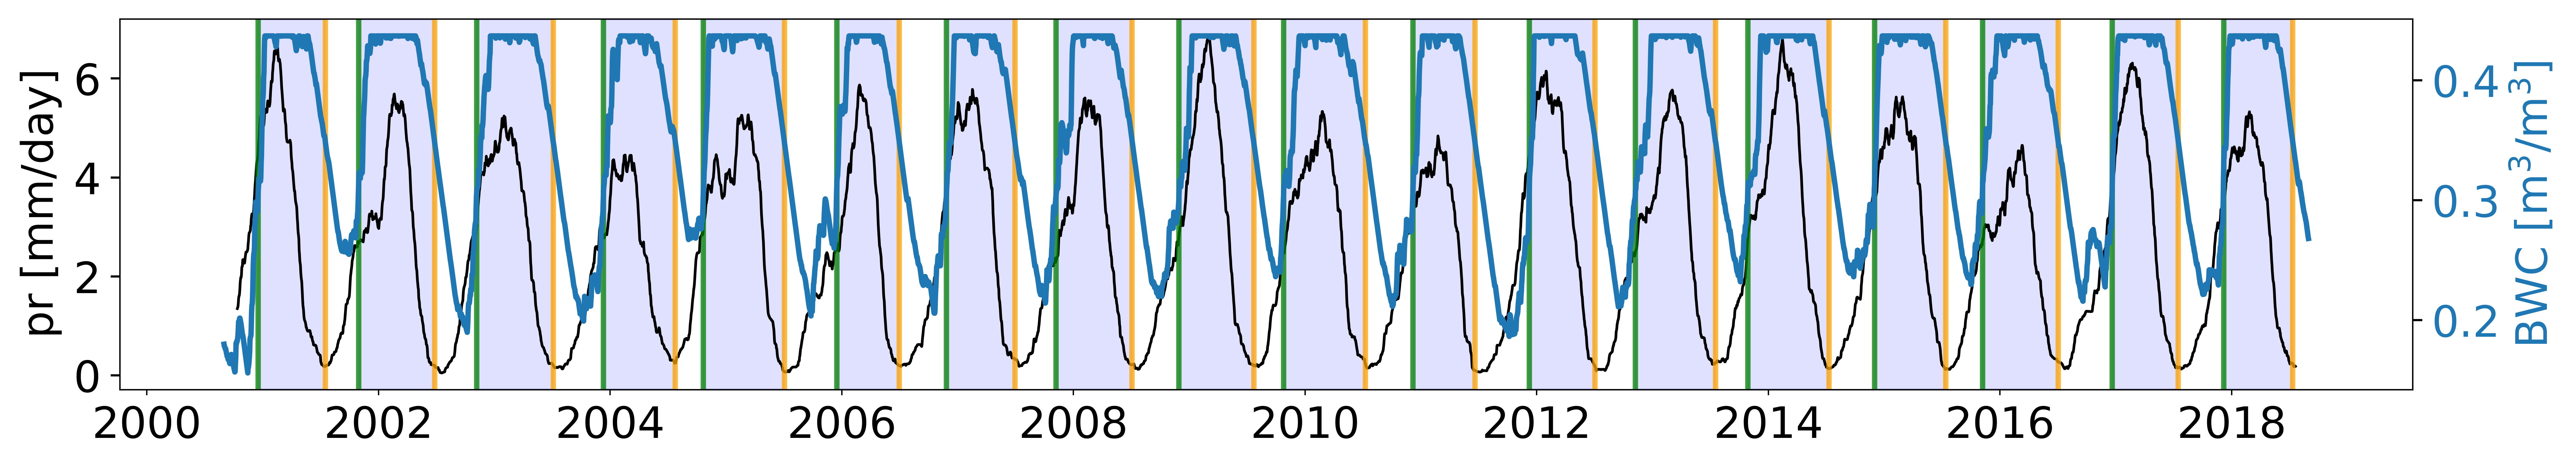

In [6]:
fig, pax = plt.subplots(figsize=(.75*18,.75*3.5),dpi=600)
sax = pax.twinx()

sax.plot(data.index,bwc,linewidth=2,zorder=11)
pax.plot(data['WRF'].rolling(window=12*7,center=True).mean(),c='k',linewidth=1,label='WRF precipitation',alpha=1)

for i,(year,bSOS,bEOS) in enumerate(zip(set(data.index.year),ons,ret)):
    bSOS = np.datetime64(f'{year}-09-01') + np.timedelta64(int(bSOS),'D')
    bEOS = np.datetime64(f'{year}-09-01') + np.timedelta64(int(bEOS),'D')
    
    pax.axvline(bSOS,c='g',alpha=.75)
    pax.axvline(bEOS,c='orange',alpha=.75)
    
    # mark wet season
    pax.axvspan(bSOS, bEOS, alpha=0.12, color='b')
    # mark dry season
    #if i != 0:
    #    pax.axvspan(save, bSOS, alpha=0.05, color='r')
    #save = bEOS
    
pax.set_ylabel('pr $[mm/day]$')
sax.set_ylabel('BWC $[m^{3}/m^{3}]$', color=default_blue);
sax.tick_params(axis='y', labelcolor=default_blue)


fig.tight_layout()
plt.savefig('./figures/FigS2.pdf')